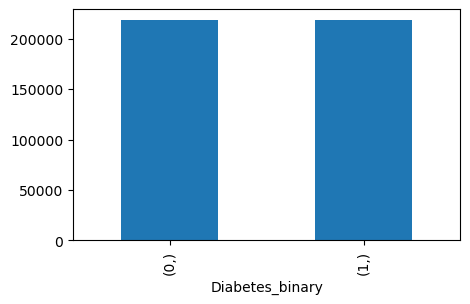

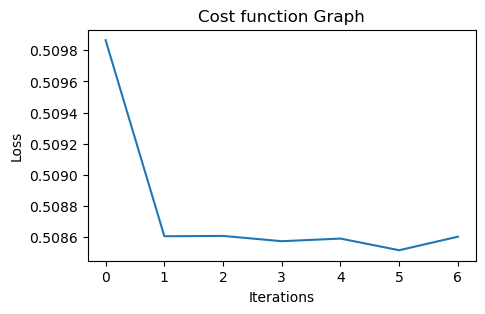

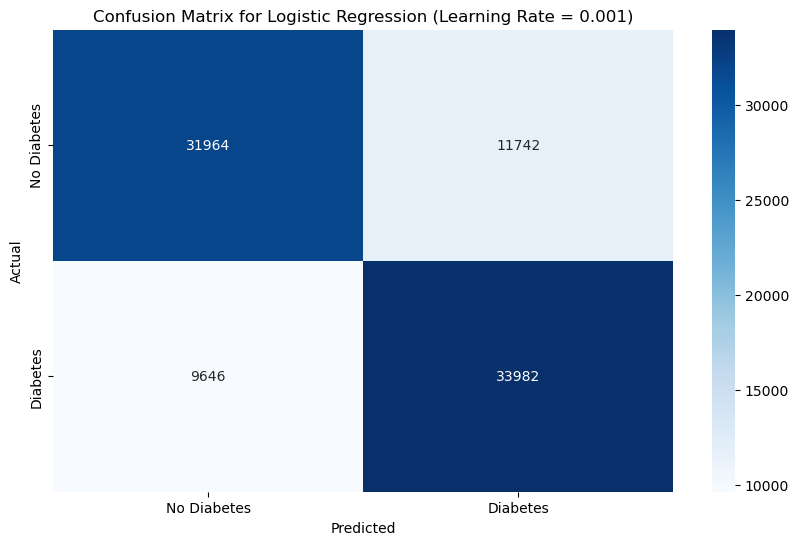

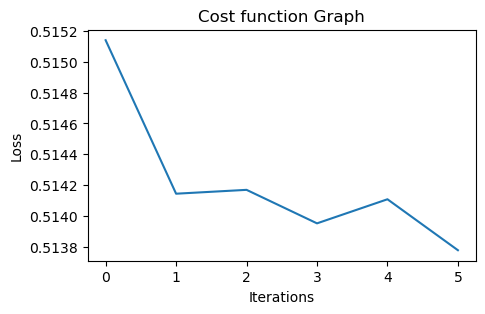

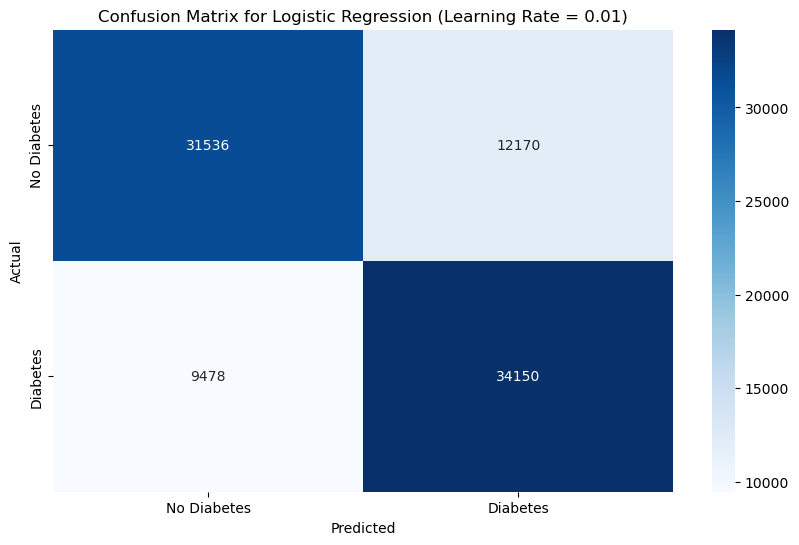

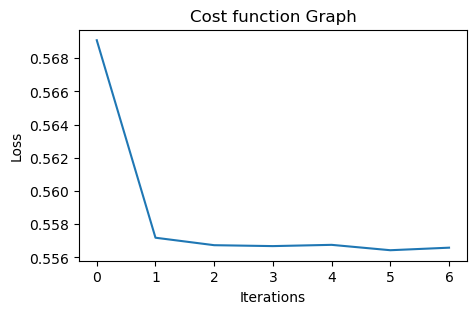

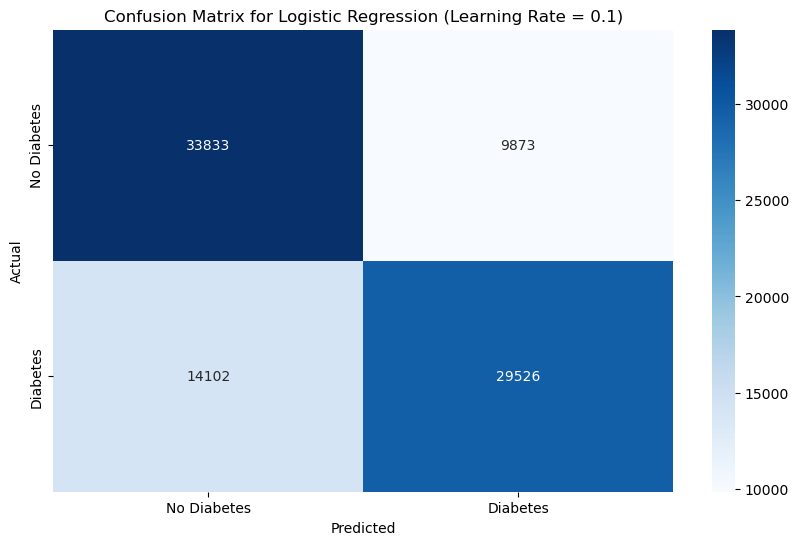

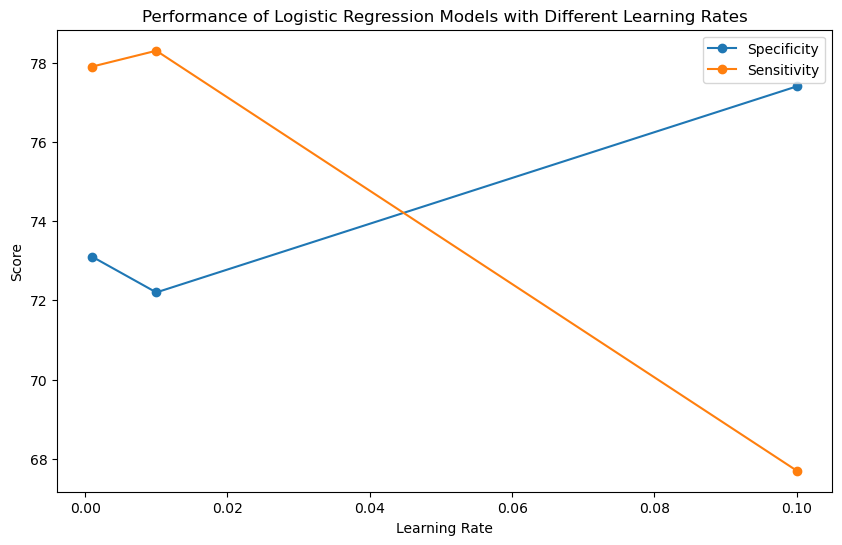

In [51]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
import scipy 
from scipy import stats 
from ucimlrepo import fetch_ucirepo 
import sys 
from io import StringIO
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
from imblearn.pipeline import Pipeline

def standardize_data(data):
    data_standardized = data.copy()
    names = data.columns
    for name in names:
        data_standardized[name] = stats.zscore(data[name])
    return data_standardized
    
# Fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# Data (as pandas dataframes)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

X = standardize_data(X)

#under-over sample
over  = SMOTE(random_state=42)
under = RandomUnderSampler(sampling_strategy='auto', random_state=42)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X, y = pipeline.fit_resample(X, y)
y.value_counts().plot(kind = 'bar')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

learning_rates = [0.001, 0.01, 0.1]
log_reg_models = []
metrics = {'specificity': [], 'sensitivity': []}

for lr in learning_rates:
    old_stdout = sys.stdout
    sys.stdout = mystdout = StringIO()
    logr = SGDClassifier(loss='log_loss',penalty='l1',learning_rate='constant',eta0=lr,max_iter=1000,random_state=42,verbose=3)
    logr.fit(X_train, np.ravel(y_train,order='C'))#y_resampled_smote)
    sys.stdout = old_stdout
    loss_history = mystdout.getvalue()
    loss_list = []
    for line in loss_history.split('\n'):
        print(line)
        if(len(line.split("loss: ")) == 1):
            continue
        loss_list.append(float(line.split("loss: ")[-1]))
        
    plt.figure()
    plt.plot(np.arange(len(loss_list)), loss_list)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title('Cost function Graph')
    plt.rcParams["figure.figsize"] = (5,3)

    y_pred = logr.predict(X_test)
    
    # Plot confusion matrix for each learning rate
    plt.figure(figsize=(10, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
    plt.title(f'Confusion Matrix for Logistic Regression (Learning Rate = {lr})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Print classification report for each learning rate
    #print(f'Classification Report for Logistic Regression (Learning Rate = {lr}):\n{classification_report(y_test, y_pred)}')
    TN, FP    = cm[0, 0], cm[0, 1]
    FN, TP    = cm[1, 0], cm[1, 1]    
    sensitivity = round(TP / float(TP + FN),3)*100
    specificity = round(TN / float(TN + FP),3)*100
    print('Specificity:        ',  round(TN / float(TN + FP),3)*100,flush=True)
    print('Sensitivity:        ',  round(TP / float(TP + FN),3)*100, "(Recall)",flush=True)
    metrics['specificity'].append(specificity)
    metrics['sensitivity'].append(sensitivity)

# Plot the metrics of Logistic Regression models in a single graph
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, metrics['specificity'], marker='o', label='Specificity')
plt.plot(learning_rates, metrics['sensitivity'], marker='o', label='Sensitivity')
plt.title("Performance of Logistic Regression Models with Different Learning Rates")
plt.xlabel("Learning Rate")
plt.ylabel("Score")
plt.legend()
plt.show()